classification multi-classes

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
data = pd.read_csv('predictive_maintenance.csv')
print(data.head())

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure  


In [3]:
print("\nValeurs manquantes :")
print(data.isnull().sum())


Valeurs manquantes :
UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64


In [6]:
print(data.columns)

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Target', 'Failure Type'],
      dtype='object')


In [8]:
X = data.drop('Failure Type', axis=1) 
y = data['Failure Type']

In [10]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [12]:
print(data.dtypes)

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                object
dtype: object


In [13]:
data = data.drop(['UDI', 'Product ID'], axis=1)

data['Type'] = LabelEncoder().fit_transform(data['Type'])

data['Failure Type'] = LabelEncoder().fit_transform(data['Failure Type'])

X = data.drop('Failure Type', axis=1)  
y = data['Failure Type']  

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [14]:
print(data.dtypes)

Type                         int64
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                 int64
dtype: object


In [15]:
class CSVDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

train_dataset = CSVDataset(X_train, y_train)
test_dataset = CSVDataset(X_test, y_test)

In [19]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [20]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialisation du modèle
input_dim = X.shape[1]
output_dim = len(np.unique(y))  # Nombre de classes
model = MLP(input_dim, output_dim)


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

In [25]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/50], Loss: 0.0676
Epoch [2/50], Loss: 0.0674
Epoch [3/50], Loss: 0.0673
Epoch [4/50], Loss: 0.0678
Epoch [5/50], Loss: 0.0671
Epoch [6/50], Loss: 0.0672
Epoch [7/50], Loss: 0.0672
Epoch [8/50], Loss: 0.0673
Epoch [9/50], Loss: 0.0670
Epoch [10/50], Loss: 0.0671
Epoch [11/50], Loss: 0.0674
Epoch [12/50], Loss: 0.0672
Epoch [13/50], Loss: 0.0670
Epoch [14/50], Loss: 0.0672
Epoch [15/50], Loss: 0.0672
Epoch [16/50], Loss: 0.0674
Epoch [17/50], Loss: 0.0668
Epoch [18/50], Loss: 0.0673
Epoch [19/50], Loss: 0.0671
Epoch [20/50], Loss: 0.0673
Epoch [21/50], Loss: 0.0677
Epoch [22/50], Loss: 0.0670
Epoch [23/50], Loss: 0.0678
Epoch [24/50], Loss: 0.0672
Epoch [25/50], Loss: 0.0673
Epoch [26/50], Loss: 0.0670
Epoch [27/50], Loss: 0.0676
Epoch [28/50], Loss: 0.0671
Epoch [29/50], Loss: 0.0670
Epoch [30/50], Loss: 0.0671
Epoch [31/50], Loss: 0.0670
Epoch [32/50], Loss: 0.0677
Epoch [33/50], Loss: 0.0671
Epoch [34/50], Loss: 0.0681
Epoch [35/50], Loss: 0.0672
Epoch [36/50], Loss: 0.0678
E

In [27]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")


Accuracy on test set: 97.40%


In [28]:
import matplotlib.pyplot as plt

# Initialisation des listes pour stocker les pertes et la précision
train_losses = []
test_losses = []
test_accuracies = []

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Calcul de la perte moyenne sur l'ensemble d'entraînement
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Évaluation du modèle sur l'ensemble de test
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calcul de la perte moyenne et de la précision sur l'ensemble de test
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")


Epoch [1/20], Train Loss: 0.0673, Test Loss: 0.0730, Test Accuracy: 97.40%
Epoch [2/20], Train Loss: 0.0671, Test Loss: 0.0743, Test Accuracy: 97.40%
Epoch [3/20], Train Loss: 0.0673, Test Loss: 0.0730, Test Accuracy: 97.40%
Epoch [4/20], Train Loss: 0.0671, Test Loss: 0.0746, Test Accuracy: 97.40%
Epoch [5/20], Train Loss: 0.0673, Test Loss: 0.0720, Test Accuracy: 97.40%
Epoch [6/20], Train Loss: 0.0673, Test Loss: 0.0727, Test Accuracy: 97.40%
Epoch [7/20], Train Loss: 0.0666, Test Loss: 0.0730, Test Accuracy: 97.40%
Epoch [8/20], Train Loss: 0.0674, Test Loss: 0.0719, Test Accuracy: 97.40%
Epoch [9/20], Train Loss: 0.0671, Test Loss: 0.0720, Test Accuracy: 97.40%
Epoch [10/20], Train Loss: 0.0672, Test Loss: 0.0720, Test Accuracy: 97.40%
Epoch [11/20], Train Loss: 0.0667, Test Loss: 0.0729, Test Accuracy: 97.40%
Epoch [12/20], Train Loss: 0.0673, Test Loss: 0.0726, Test Accuracy: 97.40%
Epoch [13/20], Train Loss: 0.0671, Test Loss: 0.0722, Test Accuracy: 97.40%
Epoch [14/20], Train 

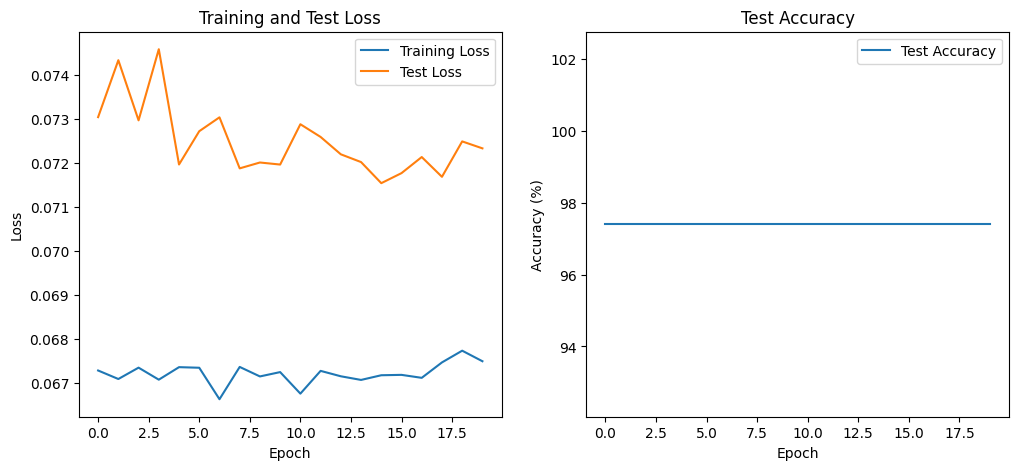

In [29]:
# Courbe de la perte d'entraînement et de test
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')

# Courbe de précision sur le test
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Test Accuracy')

plt.show()
